# Imports and Functions

In [1]:
import math 
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backend_bases import MouseButton
import matplotlib.path as path
from matplotlib.colors import ListedColormap
import numpy as np
from numpy import load
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neighbors import KDTree
from sklearn.svm import SVC
%matplotlib notebook

global selection_model
global threshold
threshold = 20 #300 works
import random
from random import randint

global cm
global cm_bright
global wales
global maxiter
global numcoords
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

wales = load('walesoutline1.npy')
wales = path.Path(wales)


maxiter = 21
numcoords = 2
selection_model = 1 #0 for 0.5, 1 for isolated, 2 for random, 3 for best

In [2]:
import math
def normpdf(x, mean, sd):
    var = float(sd)**2
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom

In [3]:
def xnew(x): 
    return (-5)+(((x+5)*(10+5))/(51+5))
def ynew(y): 
    return ((y+2)*(15))/(55)

def branin(x, a=1, b=5.1/(4*(np.pi**2)), c=5/np.pi, r=6, s=10, t=1/(8*np.pi), noise=0.1):
       
    return a*(x[1]-(b*(x[0]**2))+c*x[0]-r)**2+(s*(1-t)*np.cos(x[0]))+s

def braninColor(x, threshold):
    
    if branin((xnew(x[0]),xnew(x[1])))>threshold:
        return 1
    else:
        return 0   

In [4]:
def calculateModel():
    
    global X
    global Z
    global Z_model_pred
    global Znew
    global ZBranin
    global xx,yy
    global Big_df
    global Big_df_land


    x_min, x_max = -5, 51 
    y_min, y_max = -2, 53
    h = .5  # step size in the mesh

    Coords_df = pd.DataFrame(coords,columns=['XPos','YPos','Type'])
    DT_X_Values = Coords_df.drop(['Type'],axis=1)

    X = DT_X_Values.to_numpy().tolist()
    X = np.array(X)

    DT_Y_Values = Coords_df.drop(['XPos'],axis=1)
    DT_Y_Values = DT_Y_Values.drop(['YPos'],axis=1)
    y = DT_Y_Values.to_numpy().ravel()



    clf = SVC(probability=True, gamma = 0.01)
    clf.fit(X, y)
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
    
    ZBranin = []
    branincoords = np.c_[xx.ravel(), yy.ravel()]
    for i in range(12320):
        ZBranin.append(braninColor(branincoords[i],20))



    Z_model_prob = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z_model_prob = Z_model_prob.reshape(xx.shape)                                                      #Z is [model_probs]
    Z_model_pred = clf.predict(np.c_[xx.ravel(), yy.ravel()])[:]                        #Z_model_pred is [model_predictions]

    Big_df = pd.DataFrame(xx.ravel(), columns=['xx'])#
    Big_df.insert(1, 'yy',yy.ravel())
    Big_df.insert(2, 'Z_model_predictions', Z_model_pred.ravel())
    Big_df.insert(3, 'Z_model_predictions_flattened', 0)
    Big_df.insert(4, 'Z_model_probs', Z_model_prob.ravel())
    Big_df.insert(5, 'Z_model_probs_flattened_SEA', 0)
    Big_df.insert(6, 'Z_model_probs_flattened_0', 0)
    Big_df.insert(7, 'Surrogate_model_predictions', ZBranin)
    Big_df.insert(8, 'Surrogate_model_predictions_flattened', 0)

    for i in range(12320):

        if (wales.contains_points([(Big_df.iat[i,0],Big_df.iat[i,1])])[0]):
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_probs']
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = Big_df.iloc[i]['Surrogate_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = Big_df.iloc[i]['Z_model_probs']

        else:
            Big_df.loc[i, 'Z_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = 'SEA'
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = 0

    Z_model_predictions = Big_df["Z_model_predictions"].to_numpy()
    Z_model_predictions_flattened = Big_df["Z_model_predictions_flattened"].to_numpy()
    Z_model_probs = Big_df["Z_model_probs"].to_numpy()
#     Z_model_probs_flattened = Big_df["Z_model_probs_flattened"].to_numpy()
    Surrogate_model_predictions = Big_df["Surrogate_model_predictions"].to_numpy()
    Surrogate_model_predictions_flattened = Big_df["Surrogate_model_predictions_flattened"].to_numpy()

    Big_df_land = Big_df[Big_df['Z_model_predictions_flattened'] != 'SEA']

    Contour_model = Big_df["Z_model_probs_flattened_0"].to_numpy()
    Contour_model = Contour_model.reshape(xx.shape) 


    plt.cla()
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic_r')
    # plt.axis("off")
    plt.grid()
    ax.contourf(xx, yy, Contour_model, 40, cmap=cm, alpha=
                0.4)

    plt.plot()

    plt.show()


In [5]:
def find_isolated_point():
       
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]

    testpoints = tmp_df[['xx','yy']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        if dist>maxdist:
            maxdist = dist
            maxind = ind
            ifinal = i

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)
    plt.plot()
    plt.show()
    fig1.show()
#     print('isolated', testpoints[ifinal])
    return testpoints[ifinal]
    
def find0_5():
    
    tmp_df = Big_df.iloc[(Big_df['Z_model_probs_flattened_0']-0.50).abs().argsort()[:2]]
    value = randint(0, len(tmp_df.index)-1)
    uncertain_coord = [tmp_df.iloc[value]['xx'],tmp_df.iloc[value]['yy']]
        
    ax.scatter(uncertain_coord[0], uncertain_coord[1], c='#00FF00', s=25)
    plt.plot()
    plt.show()    
    fig1.show()
      
#     print('0_5', uncertain_coord)
    return uncertain_coord

def random_point():
    
    tmp_df = Big_df_land.iloc[:, :]
    testpoints = tmp_df[['xx','yy']].to_numpy()
                    
    ifinal = randint(0,len(testpoints.tolist()))
    
    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()
    
    fig1.show()
    
    return testpoints[ifinal]

def best():
    
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]
    score = 0

    testpoints = tmp_df[['xx','yy']].to_numpy()
    testpoints1 = tmp_df[['Z_model_probs']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        prob = testpoints1[i]
        tmp_score = dist*normpdf(prob,0.5,0.05)
        if tmp_score>score:
            ifinal = i
            distfinal = dist
            probfinal = prob
            score = tmp_score

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()

    fig1.show()
    
    find0_5()
    find_isolated_point()
    
    print(distfinal)
    print(probfinal)
    print(score)
    print('best',testpoints[ifinal])

    return testpoints[ifinal]
    
    



In [6]:
def Accuracy():
    
    correctPredictions = 0
    incorrectPredictions = 0

    for i in range(len(Big_df_land.index)):
        if ((Big_df_land.iloc[i]["Z_model_predictions"])==(Big_df_land.iloc[i]["Surrogate_model_predictions"])):
            correctPredictions+=1
        else:
            incorrectPredictions+=1


    accuracy = (correctPredictions)/((
    incorrectPredictions+correctPredictions))
    accuracyArray.append(accuracy)

    print('Accuracy is',accuracy)
    

def printGraph():
    
    xAxis = []
    for i in range(len(accuracyArray)):
        xAxis.append(i+1)

    plt.scatter(xAxis, accuracyArray) 
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy over time')
    plt.ylim(0.3, 1.0)  
    plt.show()

# Plot first graph

experiment:  0


<IPython.core.display.Javascript object>


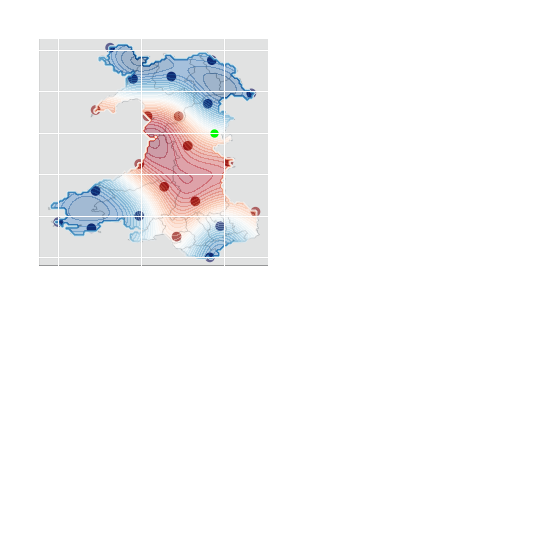

iteration  1
Accuracy is 0.5779657758123438
iteration  2
Accuracy is 0.6594885598923284
iteration  3
Accuracy is 0.6473755047106325
iteration  4
Accuracy is 0.7017881176696789
iteration  5
Accuracy is 0.6814074216496827
iteration  6
Accuracy is 0.665833493558931
iteration  7
Accuracy is 0.7373582003460873
iteration  8
Accuracy is 0.7115939242453374
iteration  9
Accuracy is 0.7744664487598538
iteration  10
Accuracy is 0.8044606806383388
iteration  11
Accuracy is 0.8113824264564506
iteration  12
Accuracy is 0.8234954816381466
iteration  13
Accuracy is 0.8429148240722938
iteration  14
Accuracy is 0.8331090174966352
iteration  15
Accuracy is 0.832532205345126
iteration  16
Accuracy is 0.8277254374158816
iteration  17
Accuracy is 0.8306094981734282
iteration  18
Accuracy is 0.8306094981734282
iteration  19
Accuracy is 0.8425302826379543
iteration  20
Accuracy is 0.8767544702941742
iteration  21
Accuracy is 0.8721399730820996
experiment:  1


<IPython.core.display.Javascript object>


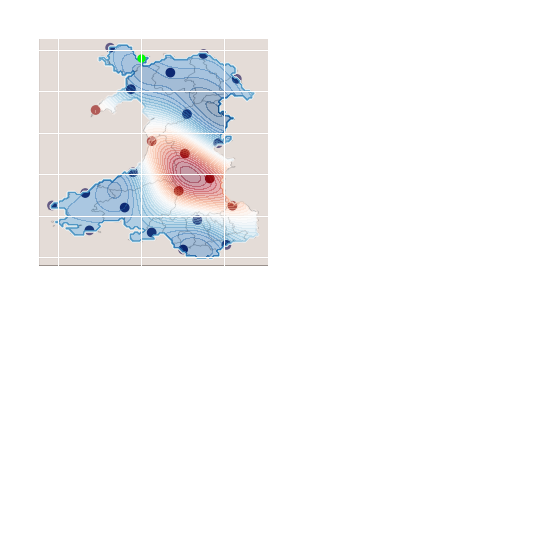

iteration  1
Accuracy is 0.505095174004999
iteration  2
Accuracy is 0.634108825225918
iteration  3
Accuracy is 0.6319938473370506
iteration  4
Accuracy is 0.631609305902711
iteration  5
Accuracy is 0.7404345318208037
iteration  6
Accuracy is 0.7037108248413767
iteration  7
Accuracy is 0.6831378581042107
iteration  8
Accuracy is 0.6602576427610075
iteration  9
Accuracy is 0.6927513939626995
iteration  10
Accuracy is 0.8283022495673908
iteration  11
Accuracy is 0.8094597192847529
iteration  12
Accuracy is 0.8098442607190924
iteration  13
Accuracy is 0.7921553547394732
iteration  14
Accuracy is 0.7840799846183426
iteration  15
Accuracy is 0.781195923860796
iteration  16
Accuracy is 0.6898673332051528
iteration  17
Accuracy is 0.6798692559123245
iteration  18
Accuracy is 0.6798692559123245
iteration  19
Accuracy is 0.7821572774466449
iteration  20
Accuracy is 0.7960007690828687
iteration  21
Accuracy is 0.788117669678908
experiment:  2


<IPython.core.display.Javascript object>


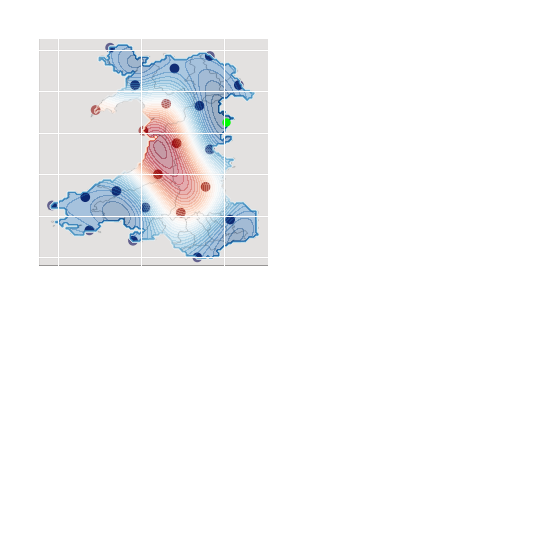

iteration  1
Accuracy is 0.4443376273793501
iteration  2
Accuracy is 0.6858296481445876
iteration  3
Accuracy is 0.6542972505287444
iteration  4
Accuracy is 0.6400692174581811
iteration  5
Accuracy is 0.8006152662949433
iteration  6
Accuracy is 0.7121707363968468
iteration  7
Accuracy is 0.6867910017304365
iteration  8
Accuracy is 0.6523745433570467
iteration  9
Accuracy is 0.6306479523168621
iteration  10
Accuracy is 0.6758315708517593
iteration  11
Accuracy is 0.6527590847913862
iteration  12
Accuracy is 0.6527590847913862
iteration  13
Accuracy is 0.8208036915977697
iteration  14
Accuracy is 0.8184964429917324
iteration  15
Accuracy is 0.7985002884060758
iteration  16
Accuracy is 0.7979234762545664
iteration  17
Accuracy is 0.8365698904056912
iteration  18
Accuracy is 0.8838684868294558
iteration  19
Accuracy is 0.8636800615266295
iteration  20
Accuracy is 0.8779080945971929
iteration  21
Accuracy is 0.8779080945971929
experiment:  3


<IPython.core.display.Javascript object>


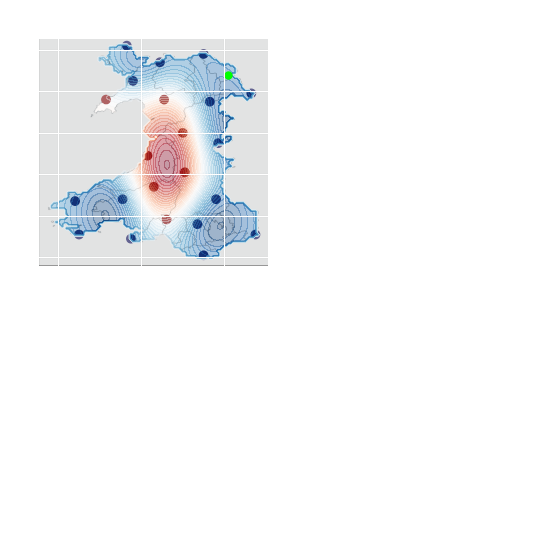

iteration  1
Accuracy is 0.5462411074793309
iteration  2
Accuracy is 0.6600653720438378
iteration  3
Accuracy is 0.720438377235147
iteration  4
Accuracy is 0.6289175158623341
iteration  5
Accuracy is 0.656412228417612
iteration  6
Accuracy is 0.7248606037300519
iteration  7
Accuracy is 0.7375504710632571
iteration  8
Accuracy is 0.6633339742357239
iteration  9
Accuracy is 0.7338973274370313
iteration  10
Accuracy is 0.729090559507787
iteration  11
Accuracy is 0.7371659296289175
iteration  12
Accuracy is 0.7277446644875986
iteration  13
Accuracy is 0.7363968467602384
iteration  14
Accuracy is 0.832532205345126
iteration  15
Accuracy is 0.8202268794462604
iteration  16
Accuracy is 0.845222072678331
iteration  17
Accuracy is 0.830801768890598
iteration  18
Accuracy is 0.8313785810421073
iteration  19
Accuracy is 0.8440684483753125
iteration  20
Accuracy is 0.8706018073447414
iteration  21
Accuracy is 0.8506056527590848
experiment:  4


<IPython.core.display.Javascript object>


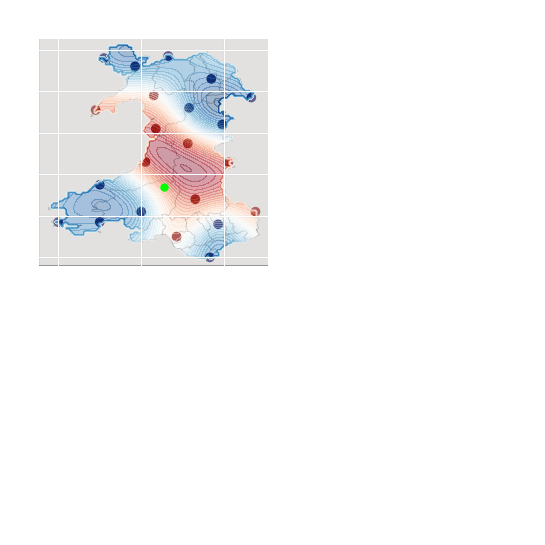

iteration  1
Accuracy is 0.6198807921553547
iteration  2
Accuracy is 0.6644875985387425
iteration  3
Accuracy is 0.6479523168621419
iteration  4
Accuracy is 0.6412228417611998
iteration  5
Accuracy is 0.6360315323976159
iteration  6
Accuracy is 0.671793885791194
iteration  7
Accuracy is 0.6981349740434531
iteration  8
Accuracy is 0.7260142280330706
iteration  9
Accuracy is 0.7087098634877909
iteration  10
Accuracy is 0.7200538358008075
iteration  11
Accuracy is 0.7385118246491059
iteration  12
Accuracy is 0.7242837915785426
iteration  13
Accuracy is 0.7396654489521246
iteration  14
Accuracy is 0.7873485868102288
iteration  15
Accuracy is 0.781195923860796
iteration  16
Accuracy is 0.8034993270524899
iteration  17
Accuracy is 0.8034993270524899
iteration  18
Accuracy is 0.8488752163045569
iteration  19
Accuracy is 0.8873293597385118
iteration  20
Accuracy is 0.8884829840415305
iteration  21
Accuracy is 0.8959815420111517
experiment:  5


<IPython.core.display.Javascript object>


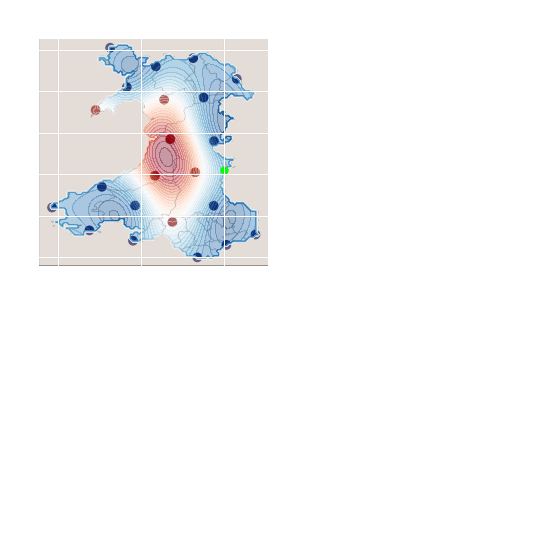

iteration  1
Accuracy is 0.40626802537973467
iteration  2
Accuracy is 0.6890982503364738
iteration  3
Accuracy is 0.6764083830032686
iteration  4
Accuracy is 0.6666025764276101
iteration  5
Accuracy is 0.7190924822149587
iteration  6
Accuracy is 0.7223610844068449
iteration  7
Accuracy is 0.7092866756393001
iteration  8
Accuracy is 0.7021726591040185
iteration  9
Accuracy is 0.705056719861565
iteration  10
Accuracy is 0.7031340126898673
iteration  11
Accuracy is 0.7029417419726975
iteration  12
Accuracy is 0.7190924822149587
iteration  13
Accuracy is 0.7190924822149587
iteration  14
Accuracy is 0.7861949625072101
iteration  15
Accuracy is 0.7981157469717362
iteration  16
Accuracy is 0.8123437800422996
iteration  17
Accuracy is 0.827340895981542
iteration  18
Accuracy is 0.8554124206883291
iteration  19
Accuracy is 0.8317631224764468
iteration  20
Accuracy is 0.8294558738704095
iteration  21
Accuracy is 0.8294558738704095
experiment:  6


<IPython.core.display.Javascript object>


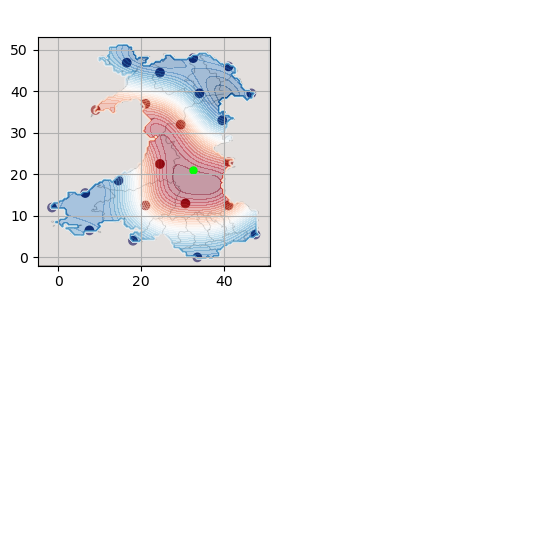

iteration  1
Accuracy is 0.5696981349740434
iteration  2
Accuracy is 0.7133243606998654
iteration  3
Accuracy is 0.6858296481445876
iteration  4
Accuracy is 0.7635070178811767
iteration  5
Accuracy is 0.7850413382041915
iteration  6
Accuracy is 0.7498557969621227
iteration  7
Accuracy is 0.745241299750048
iteration  8
Accuracy is 0.7267833109017496
iteration  9
Accuracy is 0.7306287252451452
iteration  10
Accuracy is 0.7573543549317439
iteration  11
Accuracy is 0.7533166698711786
iteration  12
Accuracy is 0.8011920784464526
iteration  13
Accuracy is 0.8023457027494713
iteration  14
Accuracy is 0.7917708133051337
iteration  15
Accuracy is 0.7861949625072101
iteration  16
Accuracy is 0.8086906364160739
iteration  17
Accuracy is 0.8300326860219188
iteration  18
Accuracy is 0.8300326860219188
iteration  19
Accuracy is 0.8567583157085176
iteration  20
Accuracy is 0.8567583157085176
iteration  21
Accuracy is 0.8707940780619112
experiment:  7


<IPython.core.display.Javascript object>


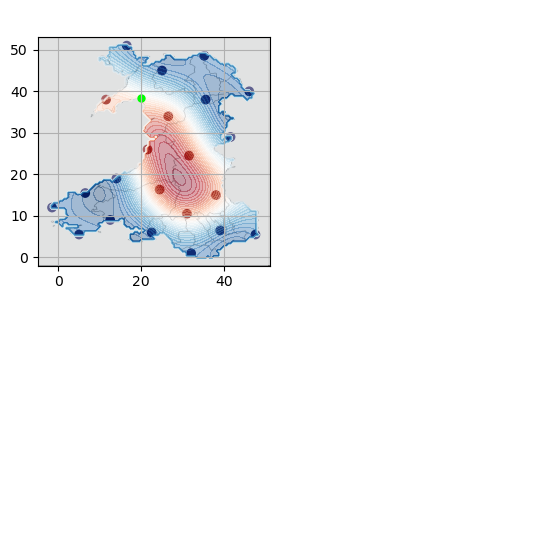

iteration  1
Accuracy is 0.635070178811767
iteration  2
Accuracy is 0.7250528744472217
iteration  3
Accuracy is 0.6960199961545857
iteration  4
Accuracy is 0.7381272832147664
iteration  5
Accuracy is 0.7139011728513748
iteration  6
Accuracy is 0.70082676408383
iteration  7
Accuracy is 0.7488944433762738
iteration  8
Accuracy is 0.7775427802345702
iteration  9
Accuracy is 0.7933089790424919
iteration  10
Accuracy is 0.8629109786579504
iteration  11
Accuracy is 0.8650259565468179
iteration  12
Accuracy is 0.8281099788502211
iteration  13
Accuracy is 0.8192655258604115
iteration  14
Accuracy is 0.8434916362238031
iteration  15
Accuracy is 0.82907133243607
iteration  16
Accuracy is 0.8419534704864449
iteration  17
Accuracy is 0.8536819842338011
iteration  18
Accuracy is 0.8532974427994616
iteration  19
Accuracy is 0.8723322437992693
iteration  20
Accuracy is 0.8715631609305903
iteration  21
Accuracy is 0.8715631609305903
experiment:  8


<IPython.core.display.Javascript object>


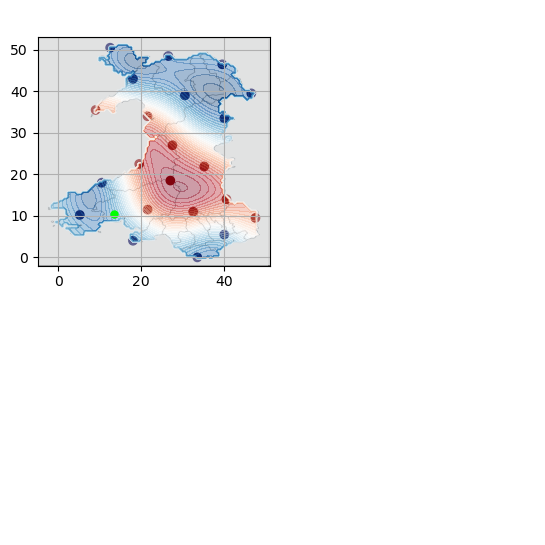

iteration  1
Accuracy is 0.5514324168429148
iteration  2
Accuracy is 0.6783310901749664
iteration  3
Accuracy is 0.6577581234378004
iteration  4
Accuracy is 0.6421841953470486
iteration  5
Accuracy is 0.7573543549317439
iteration  6
Accuracy is 0.7596616035377812
iteration  7
Accuracy is 0.7244760622957124
iteration  8
Accuracy is 0.7723514708709863
iteration  9
Accuracy is 0.7458181119015574
iteration  10
Accuracy is 0.8146510286483368
iteration  11
Accuracy is 0.8031147856181503
iteration  12
Accuracy is 0.7810036531436262
iteration  13
Accuracy is 0.7900403768506057
iteration  14
Accuracy is 0.8104210728706018
iteration  15
Accuracy is 0.8081138242645645
iteration  16
Accuracy is 0.8096519900019227
iteration  17
Accuracy is 0.8065756585272063
iteration  18
Accuracy is 0.8432993655066333
iteration  19
Accuracy is 0.8431070947894636
iteration  20
Accuracy is 0.8359930782541819
iteration  21
Accuracy is 0.8694481830417228
experiment:  9


<IPython.core.display.Javascript object>


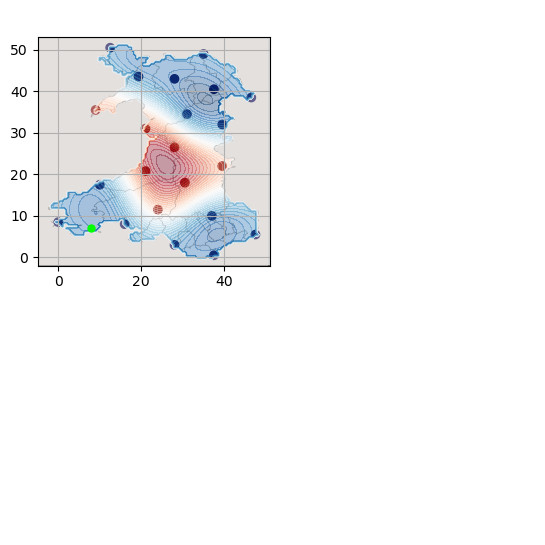

iteration  1
Accuracy is 0.5945010574889444
iteration  2
Accuracy is 0.6808306094981734
iteration  3
Accuracy is 0.662372620649875
iteration  4
Accuracy is 0.6537204383772351
iteration  5
Accuracy is 0.6467986925591233
iteration  6
Accuracy is 0.7317823495481638
iteration  7
Accuracy is 0.7258219573159008
iteration  8
Accuracy is 0.7031340126898673
iteration  9
Accuracy is 0.7331282445683522
iteration  10
Accuracy is 0.7271678523360892
iteration  11
Accuracy is 0.6894827917708133
iteration  12
Accuracy is 0.6702557200538358
iteration  13
Accuracy is 0.7492789848106134
iteration  14
Accuracy is 0.8140742164968275
iteration  15
Accuracy is 0.8133051336281484
iteration  16
Accuracy is 0.8133051336281484
iteration  17
Accuracy is 0.8188809844260719
iteration  18
Accuracy is 0.8340703710824842
iteration  19
Accuracy is 0.8340703710824842
iteration  20
Accuracy is 0.8340703710824842
iteration  21
Accuracy is 0.8402230340319169
experiment:  10


<IPython.core.display.Javascript object>


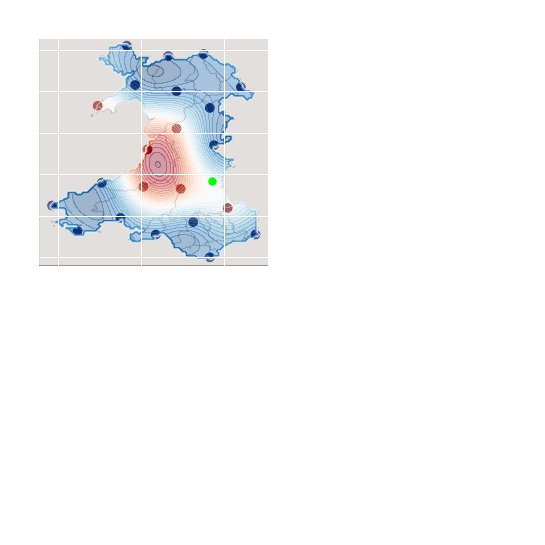

iteration  1
Accuracy is 0.5612382234185733
iteration  2
Accuracy is 0.6173812728321476
iteration  3
Accuracy is 0.6139203999230917
iteration  4
Accuracy is 0.8006152662949433
iteration  5
Accuracy is 0.7181311286291098
iteration  6
Accuracy is 0.8040761392039992
iteration  7
Accuracy is 0.7450490290328783
iteration  8
Accuracy is 0.6727552393770428
iteration  9
Accuracy is 0.6587194770236493
iteration  10
Accuracy is 0.6679484714477985
iteration  11
Accuracy is 0.8084983656989041
iteration  12
Accuracy is 0.8063833878100365
iteration  13
Accuracy is 0.7963853105172082
iteration  14
Accuracy is 0.7963853105172082
iteration  15
Accuracy is 0.7798500288406076
iteration  16
Accuracy is 0.8096519900019227
iteration  17
Accuracy is 0.8096519900019227
iteration  18
Accuracy is 0.8088829071332436
iteration  19
Accuracy is 0.8379157854258796
iteration  20
Accuracy is 0.8090751778504134
iteration  21
Accuracy is 0.8090751778504134
experiment:  11


<IPython.core.display.Javascript object>


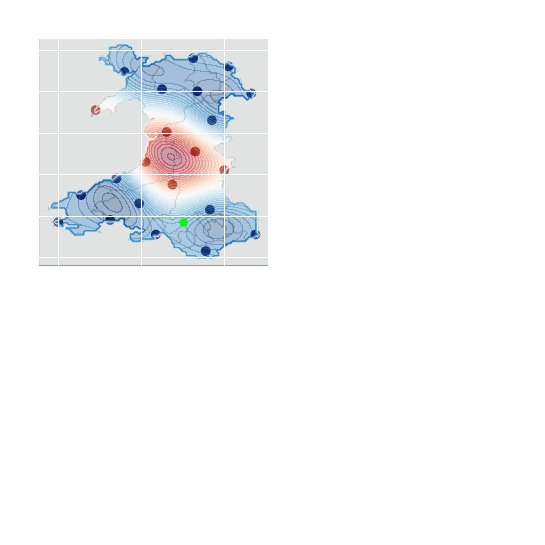

iteration  1
Accuracy is 0.48202268794462605
iteration  2
Accuracy is 0.6942895597000577
iteration  3
Accuracy is 0.6833301288213806
iteration  4
Accuracy is 0.671793885791194
iteration  5
Accuracy is 0.6600653720438378
iteration  6
Accuracy is 0.7119784656796769
iteration  7
Accuracy is 0.6989040569121323
iteration  8
Accuracy is 0.6960199961545857
iteration  9
Accuracy is 0.6921745818111902
iteration  10
Accuracy is 0.7842722553355124
iteration  11
Accuracy is 0.7935012497596616
iteration  12
Accuracy is 0.813689675062488
iteration  13
Accuracy is 0.813689675062488
iteration  14
Accuracy is 0.7685060565275909
iteration  15
Accuracy is 0.7558161891943856
iteration  16
Accuracy is 0.7558161891943856
iteration  17
Accuracy is 0.7552393770428764
iteration  18
Accuracy is 0.7827340895981542
iteration  19
Accuracy is 0.7719669294366468
iteration  20
Accuracy is 0.7973466641030571
iteration  21
Accuracy is 0.7973466641030571
experiment:  12


<IPython.core.display.Javascript object>


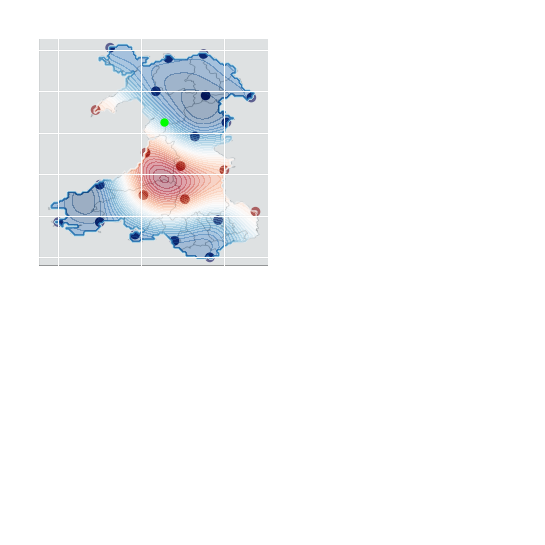

iteration  1
Accuracy is 0.5556623726206499
iteration  2
Accuracy is 0.6456450682561046
iteration  3
Accuracy is 0.6331474716400692
iteration  4
Accuracy is 0.6266102672562969
iteration  5
Accuracy is 0.6237262064987502
iteration  6
Accuracy is 0.6206498750240338
iteration  7
Accuracy is 0.619688521438185
iteration  8
Accuracy is 0.6485291290136512
iteration  9
Accuracy is 0.6835223995385503
iteration  10
Accuracy is 0.8002307248606038
iteration  11
Accuracy is 0.7973466641030571
iteration  12
Accuracy is 0.7898481061334359
iteration  13
Accuracy is 0.804268409921169
iteration  14
Accuracy is 0.804268409921169
iteration  15
Accuracy is 0.8190732551432417
iteration  16
Accuracy is 0.8098442607190924
iteration  17
Accuracy is 0.813689675062488
iteration  18
Accuracy is 0.813689675062488
iteration  19
Accuracy is 0.813689675062488
iteration  20
Accuracy is 0.813689675062488
iteration  21
Accuracy is 0.8363776196885214
experiment:  13


<IPython.core.display.Javascript object>


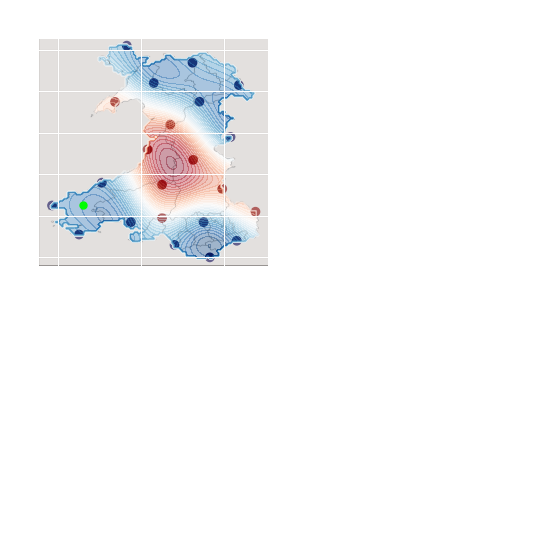

iteration  1
Accuracy is 0.5716208421457412
iteration  2
Accuracy is 0.6148817535089406
iteration  3
Accuracy is 0.6187271678523361
iteration  4
Accuracy is 0.7788886752547587
iteration  5
Accuracy is 0.7354354931743895
iteration  6
Accuracy is 0.7075562391847722
iteration  7
Accuracy is 0.7842722553355124
iteration  8
Accuracy is 0.8069601999615459
iteration  9
Accuracy is 0.8054220342241877
iteration  10
Accuracy is 0.8659873101326668
iteration  11
Accuracy is 0.8644491443953086
iteration  12
Accuracy is 0.8540665256681408
iteration  13
Accuracy is 0.8475293212843684
iteration  14
Accuracy is 0.8419534704864449
iteration  15
Accuracy is 0.8415689290521053
iteration  16
Accuracy is 0.8269563545472025
iteration  17
Accuracy is 0.8306094981734282
iteration  18
Accuracy is 0.8481061334358777
iteration  19
Accuracy is 0.8554124206883291
iteration  20
Accuracy is 0.8554124206883291
iteration  21
Accuracy is 0.8742549509709672
experiment:  14


<IPython.core.display.Javascript object>


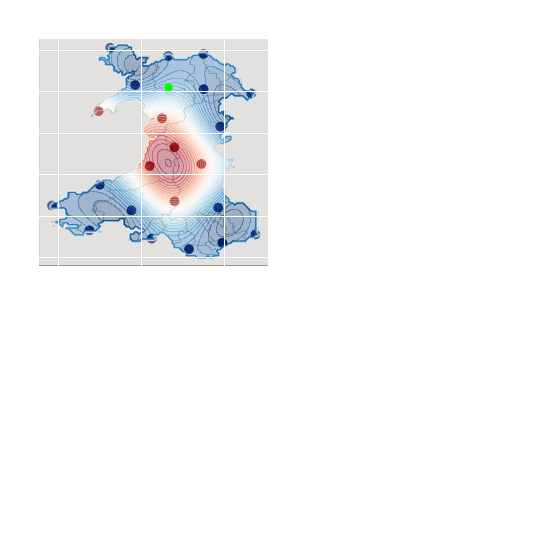

iteration  1
Accuracy is 0.4226110363391655
iteration  2
Accuracy is 0.6216112286098827
iteration  3
Accuracy is 0.6246875600845991
iteration  4
Accuracy is 0.625648913670448
iteration  5
Accuracy is 0.681215150932513
iteration  6
Accuracy is 0.6694866371851567
iteration  7
Accuracy is 0.660642184195347
iteration  8
Accuracy is 0.7354354931743895
iteration  9
Accuracy is 0.7373582003460873
iteration  10
Accuracy is 0.7540857527398577
iteration  11
Accuracy is 0.8052297635070179
iteration  12
Accuracy is 0.7783118631032494
iteration  13
Accuracy is 0.7796577581234378
iteration  14
Accuracy is 0.8234954816381466
iteration  15
Accuracy is 0.8088829071332436
iteration  16
Accuracy is 0.8294558738704095
iteration  17
Accuracy is 0.8304172274562585
iteration  18
Accuracy is 0.8309940396077677
iteration  19
Accuracy is 0.8288790617189002
iteration  20
Accuracy is 0.8288790617189002
iteration  21
Accuracy is 0.8292636031532398
experiment:  15


<IPython.core.display.Javascript object>


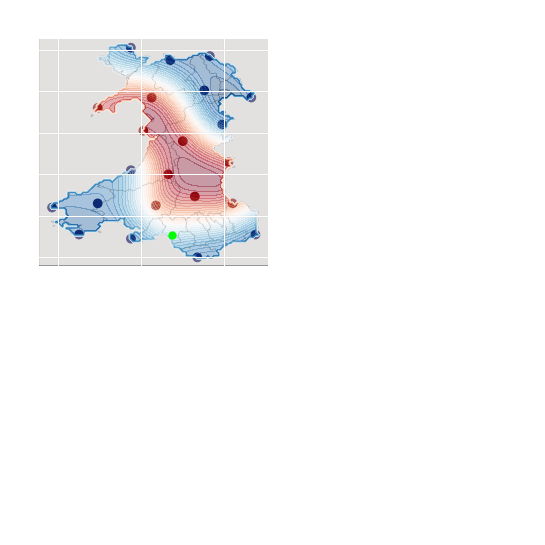

iteration  1
Accuracy is 0.6021918861757354
iteration  2
Accuracy is 0.706018073447414
iteration  3
Accuracy is 0.688905979619304
iteration  4
Accuracy is 0.7117861949625072
iteration  5
Accuracy is 0.7033262834070371
iteration  6
Accuracy is 0.6904441453566622
iteration  7
Accuracy is 0.6694866371851567
iteration  8
Accuracy is 0.6594885598923284
iteration  9
Accuracy is 0.7390886368006153
iteration  10
Accuracy is 0.7625456642953278
iteration  11
Accuracy is 0.7506248798308017
iteration  12
Accuracy is 0.7490867140934435
iteration  13
Accuracy is 0.7494712555277832
iteration  14
Accuracy is 0.7592770621034416
iteration  15
Accuracy is 0.8071524706787157
iteration  16
Accuracy is 0.7998461834262642
iteration  17
Accuracy is 0.8217650451836185
iteration  18
Accuracy is 0.8231109402038069
iteration  19
Accuracy is 0.8202268794462604
iteration  20
Accuracy is 0.8208036915977697
iteration  21
Accuracy is 0.8421457412036147
experiment:  16


<IPython.core.display.Javascript object>


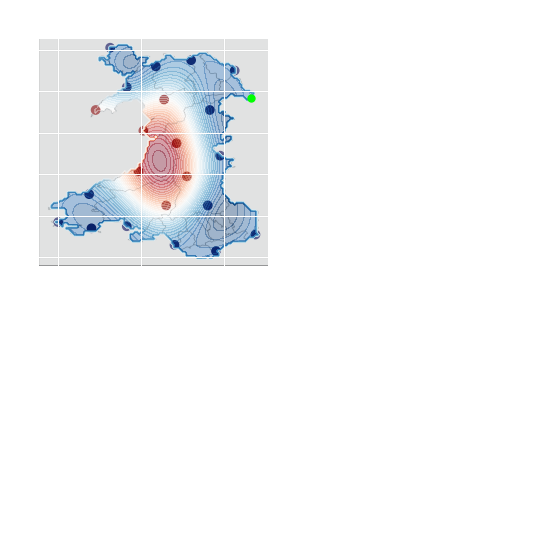

iteration  1
Accuracy is 0.500865218227264
iteration  2
Accuracy is 0.6587194770236493
iteration  3
Accuracy is 0.6423764660642184
iteration  4
Accuracy is 0.635070178811767
iteration  5
Accuracy is 0.629878869448183
iteration  6
Accuracy is 0.6266102672562969
iteration  7
Accuracy is 0.6779465487406268
iteration  8
Accuracy is 0.67525475870025
iteration  9
Accuracy is 0.6731397808113824
iteration  10
Accuracy is 0.6739088636800615
iteration  11
Accuracy is 0.6842914824072294
iteration  12
Accuracy is 0.731590078830994
iteration  13
Accuracy is 0.7523553162853297
iteration  14
Accuracy is 0.7527398577196693
iteration  15
Accuracy is 0.7525475870024996
iteration  16
Accuracy is 0.7842722553355124
iteration  17
Accuracy is 0.7925398961738127
iteration  18
Accuracy is 0.7961930398000384
iteration  19
Accuracy is 0.8234954816381466
iteration  20
Accuracy is 0.8231109402038069
iteration  21
Accuracy is 0.8231109402038069
experiment:  17


<IPython.core.display.Javascript object>


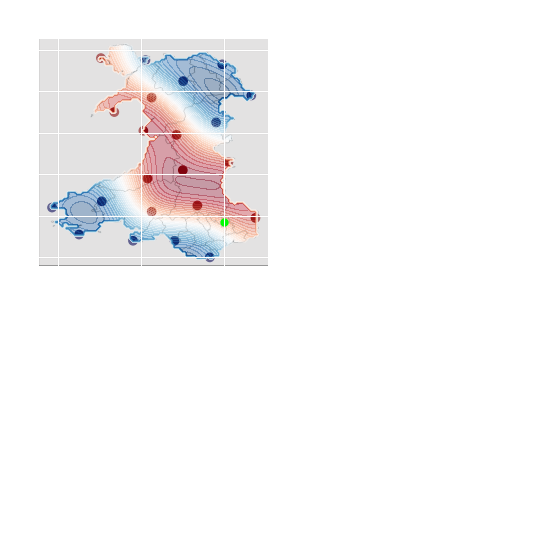

iteration  1
Accuracy is 0.49701980388386846
iteration  2
Accuracy is 0.588925206691021
iteration  3
Accuracy is 0.5971928475293213
iteration  4
Accuracy is 0.6639107863872332
iteration  5
Accuracy is 0.6833301288213806
iteration  6
Accuracy is 0.7079407806191117
iteration  7
Accuracy is 0.7185156700634493
iteration  8
Accuracy is 0.7375504710632571
iteration  9
Accuracy is 0.7450490290328783
iteration  10
Accuracy is 0.7438954047298596
iteration  11
Accuracy is 0.7321668909825033
iteration  12
Accuracy is 0.7667756200730629
iteration  13
Accuracy is 0.7921553547394732
iteration  14
Accuracy is 0.7931167083253221
iteration  15
Accuracy is 0.8225341280522976
iteration  16
Accuracy is 0.8181119015573928
iteration  17
Accuracy is 0.8183041722745625
iteration  18
Accuracy is 0.8183041722745625
iteration  19
Accuracy is 0.801768890597962
iteration  20
Accuracy is 0.8029225149009805
iteration  21
Accuracy is 0.8031147856181503
experiment:  18


<IPython.core.display.Javascript object>


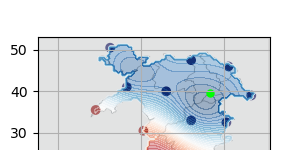

iteration  1
Accuracy is 0.39030955585464333
iteration  2
Accuracy is 0.7023649298211883
iteration  3
Accuracy is 0.6806383387810037
iteration  4
Accuracy is 0.6656412228417612
iteration  5
Accuracy is 0.6542972505287444
iteration  6
Accuracy is 0.6417996539127091
iteration  7
Accuracy is 0.6819842338011921
iteration  8
Accuracy is 0.6698711786194963
iteration  9
Accuracy is 0.6498750240338397
iteration  10
Accuracy is 0.6479523168621419
iteration  11
Accuracy is 0.6464141511247837
iteration  12
Accuracy is 0.7442799461641992
iteration  13
Accuracy is 0.8217650451836185
iteration  14
Accuracy is 0.8269563545472025
iteration  15
Accuracy is 0.8177273601230532
iteration  16
Accuracy is 0.8177273601230532
iteration  17
Accuracy is 0.8177273601230532
iteration  18
Accuracy is 0.8233032109209767
iteration  19
Accuracy is 0.8233032109209767
iteration  20
Accuracy is 0.8233032109209767
iteration  21
Accuracy is 0.8167660065372044
experiment:  19


<IPython.core.display.Javascript object>


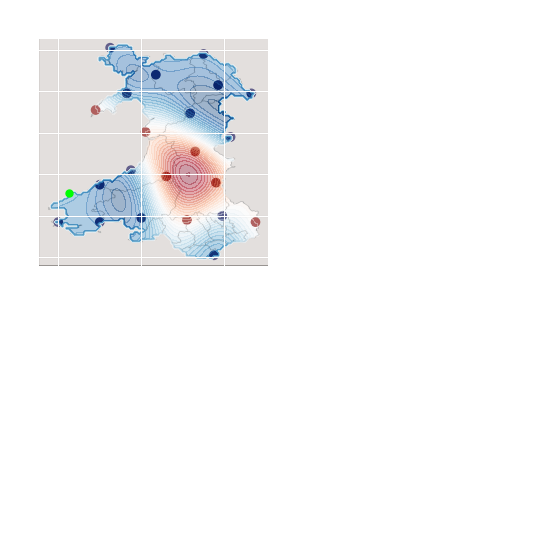

iteration  1
Accuracy is 0.5673908863680062
iteration  2
Accuracy is 0.6312247644683715
iteration  3
Accuracy is 0.6223803114785618
iteration  4
Accuracy is 0.6194962507210152
iteration  5
Accuracy is 0.6175735435493175
iteration  6
Accuracy is 0.6637185156700635
iteration  7
Accuracy is 0.6587194770236493
iteration  8
Accuracy is 0.6546817919630841
iteration  9
Accuracy is 0.6971736204576043
iteration  10
Accuracy is 0.7352432224572197
iteration  11
Accuracy is 0.7244760622957124
iteration  12
Accuracy is 0.7158238800230725
iteration  13
Accuracy is 0.8306094981734282
iteration  14
Accuracy is 0.835031724668333
iteration  15
Accuracy is 0.8436839069409728
iteration  16
Accuracy is 0.8423380119207845
iteration  17
Accuracy is 0.8423380119207845
iteration  18
Accuracy is 0.8296481445875793
iteration  19
Accuracy is 0.8106133435877716
iteration  20
Accuracy is 0.8106133435877716
iteration  21
Accuracy is 0.8079215535473947
experiment:  20


<IPython.core.display.Javascript object>


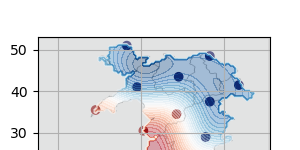

iteration  1
Accuracy is 0.5654681791963084
iteration  2
Accuracy is 0.6792924437608152
iteration  3
Accuracy is 0.6579503941549703
iteration  4
Accuracy is 0.847913862718708
iteration  5
Accuracy is 0.8002307248606038
iteration  6
Accuracy is 0.7317823495481638
iteration  7
Accuracy is 0.6569890405691213
iteration  8
Accuracy is 0.6464141511247837
iteration  9
Accuracy is 0.6394924053066718
iteration  10
Accuracy is 0.7669678907902326
iteration  11
Accuracy is 0.7940780619111709
iteration  12
Accuracy is 0.773505095174005
iteration  13
Accuracy is 0.7700442222649491
iteration  14
Accuracy is 0.8190732551432417
iteration  15
Accuracy is 0.8186887137089022
iteration  16
Accuracy is 0.8490674870217266
iteration  17
Accuracy is 0.8415689290521053
iteration  18
Accuracy is 0.8609882714862527
iteration  19
Accuracy is 0.8671409344356854
iteration  20
Accuracy is 0.8677177465871948
iteration  21
Accuracy is 0.8736781388194578


In [7]:
from random import randint
import time

valid_seeds = [4,27,12,15,17,21,23,24,25,28,31,32,35,36,37,41,42,43,45,48,420]

Results = []

for j in range(len(valid_seeds)):
    
    random.seed(valid_seeds[j])

    print('experiment: ',j)                            

    num = 100
    x = np.linspace(-5, 51, num)
    y = np.linspace(-2, 53, num)
    global landpoints 
    landpoints = []

    for i in range(num):
        for j in range(num):
            if wales.contains_points([(x[i],y[j])]):
                landpoints.append([x[i],y[j]])

    landpoints = np.asarray(landpoints, dtype=np.float32)

    i=0 
    coords = []

    for i in range(numcoords):
        value = randint(0, landpoints.size/2)
        coords.append((landpoints[value][0],
                            landpoints[value][1],
                            braninColor(landpoints[value],threshold)))
        i+=1

    global fig1,ax
    fig1, ax = plt.subplots(figsize = (3,3))
    ax.set_xlim(-5,51)
    ax.set_ylim(-2,53)
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic')
    # plt.axis("off")
    plt.grid()
    # cid = fig1.canvas.mpl_connect('button_press_event', Helicopter)

    fig1.show()
    fig1.canvas.draw()

    global accuracyArray
    accuracyArray = []

    for i in range(maxiter):
        plt.pause(1)
        print('iteration ',i+1)
    #     print('Calculating Model... ')
        calculateModel()
        plt.pause(1)
        fig1.canvas.draw()    
        Accuracy()
    #     print('Finding Isolated Point')
        if(i!=maxiter):
                     #0 for 0.5, 1 for isolated, 2 for random

            if(selection_model == 0):    
                nextpoint = find0_5()
            elif(selection_model==1):
                nextpoint=find_isolated_point()
            elif(selection_model==2):
                nextpoint = random_point()
            elif(selection_model==3):
                nextpoint = best()
            plt.pause(1)
            fig1.canvas.draw()
            coords.append((nextpoint[0], nextpoint[1], braninColor(nextpoint,threshold)))  
            plt.pause(1)
            fig1.canvas.draw()

    plt.close()
    
    Results.append(accuracyArray)
    
    

In [8]:
print('Highest Accuracy =',"{:.2f}".format((max(accuracyArray)*100)),'%')
print('Improvement is =', "{:.2f}".format((max(accuracyArray)-accuracyArray[0])*100),'%')

Highest Accuracy = 87.37 %
Improvement is = 30.82 %


In [11]:
np.savetxt('braninIsolatedrbf', Results)